In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fix random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Dataset Paths and Classes
data_dir = r'C:\Users\liuha\Downloads\APS360 Project Dataset'
class_dirs = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
num_classes = len(class_dirs)

# Data Transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Custom Dataset Class
class LungCancerDataset(Dataset):
    def __init__(self, images_dir, class_dirs, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_dirs)}

        for class_name in class_dirs:
            class_path = os.path.join(images_dir, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image_path = self.images[idx]
            image = Image.open(image_path).convert('RGB')
            gray_image = np.array(Image.open(image_path).convert('L'))
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            raise e

        mean = np.mean(gray_image)
        variance = np.var(gray_image)
        contrast = np.max(gray_image) - np.min(gray_image)
        knowledge_features = torch.tensor([mean, variance, contrast], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, knowledge_features, torch.tensor(label, dtype=torch.long)

# Create Dataset and Split
dataset = LungCancerDataset(data_dir, class_dirs, transform=data_transforms)

# Fix random seed for data splitting
generator = torch.Generator().manual_seed(seed)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=generator
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# GAN Components
class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim=100, class_dim=10, img_channels=3):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, class_dim)
        input_dim = z_dim + class_dim
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 1024, kernel_size=4, stride=1, padding=0),  # Output: 4x4
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),    # Output: 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),     # Output: 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),     # Output: 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),      # Output: 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),  # Output: 128x128
            nn.Tanh(),
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)    # Resize to 224x224
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # [batch_size, class_dim, 1, 1]
        input = torch.cat((noise, label_embedding), dim=1)
        return self.gen(input)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, class_dim=10, img_channels=3):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, class_dim)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_channels + class_dim, 64, kernel_size=4, stride=2, padding=1),  # Output: 112x112
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 56x56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: 28x28
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: 14x14
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # Output: 7x7
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.final_layer = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=7, stride=1, padding=0),  # Output: 1x1
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.expand(labels.size(0), -1, img.size(2), img.size(3))
        input = torch.cat((img, label_embedding), dim=1)
        x = self.conv_layers(input)
        x = self.final_layer(x)
        return x.view(-1, 1)

# Initialize weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

# Train GAN
def train_cgan(train_loader, z_dim=100, class_dim=10, epochs=50):
    generator = ConditionalGenerator(z_dim=z_dim, class_dim=class_dim).to(device)
    discriminator = ConditionalDiscriminator(class_dim=class_dim).to(device)

    # Apply weights initialization
    generator.apply(weights_init)
    discriminator.apply(weights_init)

    criterion = nn.BCELoss()
    optim_gen = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optim_disc = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        print(f"Starting Epoch {epoch+1}/{epochs}...")
        epoch_loss_d = 0.0
        epoch_loss_g = 0.0
        num_batches = len(train_loader)

        with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for i, (real_imgs, _, labels) in enumerate(train_loader):
                real_imgs = real_imgs.to(device)
                labels = labels.to(device)
                batch_size = real_imgs.size(0)

                # Train Discriminator
                discriminator.zero_grad()
                real_output = discriminator(real_imgs, labels)
                real_loss = criterion(real_output, torch.ones_like(real_output, device=device))

                noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
                fake_imgs = generator(noise, labels)
                fake_output = discriminator(fake_imgs.detach(), labels)
                fake_loss = criterion(fake_output, torch.zeros_like(fake_output, device=device))

                disc_loss = real_loss + fake_loss
                disc_loss.backward()
                optim_disc.step()

                # Train Generator
                generator.zero_grad()
                fake_imgs = generator(noise, labels)
                output = discriminator(fake_imgs, labels)
                gen_loss = criterion(output, torch.ones_like(output, device=device))
                gen_loss.backward()
                optim_gen.step()

                # Update epoch losses
                epoch_loss_d += disc_loss.item()
                epoch_loss_g += gen_loss.item()

                pbar.set_postfix({"D Loss": f"{disc_loss.item():.4f}", "G Loss": f"{gen_loss.item():.4f}"})
                pbar.update(1)

        avg_loss_d = epoch_loss_d / num_batches
        avg_loss_g = epoch_loss_g / num_batches
        print(f"Epoch [{epoch + 1}/{epochs}] Completed | Avg D Loss: {avg_loss_d:.4f} | Avg G Loss: {avg_loss_g:.4f}")

    return generator

# Start training
generator = train_cgan(train_loader)


Using device: cuda
Starting Epoch 1/50...


Epoch 1/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.09s/batch, D Loss=2.9542, G Loss=18.4707]


Epoch [1/50] Completed | Avg D Loss: 1.1551 | Avg G Loss: 3.9732
Starting Epoch 2/50...


Epoch 2/50: 100%|██████████████████████████████████| 165/165 [02:53<00:00,  1.05s/batch, D Loss=0.4617, G Loss=11.8786]


Epoch [2/50] Completed | Avg D Loss: 0.5743 | Avg G Loss: 5.4945
Starting Epoch 3/50...


Epoch 3/50: 100%|███████████████████████████████████| 165/165 [02:51<00:00,  1.04s/batch, D Loss=2.4890, G Loss=6.8549]


Epoch [3/50] Completed | Avg D Loss: 0.6561 | Avg G Loss: 4.5145
Starting Epoch 4/50...


Epoch 4/50: 100%|███████████████████████████████████| 165/165 [02:49<00:00,  1.03s/batch, D Loss=0.1577, G Loss=7.6749]


Epoch [4/50] Completed | Avg D Loss: 0.7304 | Avg G Loss: 4.9409
Starting Epoch 5/50...


Epoch 5/50: 100%|███████████████████████████████████| 165/165 [03:01<00:00,  1.10s/batch, D Loss=0.5928, G Loss=2.2361]


Epoch [5/50] Completed | Avg D Loss: 0.7601 | Avg G Loss: 5.4290
Starting Epoch 6/50...


Epoch 6/50: 100%|███████████████████████████████████| 165/165 [03:01<00:00,  1.10s/batch, D Loss=0.5610, G Loss=3.2919]


Epoch [6/50] Completed | Avg D Loss: 0.7581 | Avg G Loss: 5.7052
Starting Epoch 7/50...


Epoch 7/50: 100%|███████████████████████████████████| 165/165 [03:03<00:00,  1.11s/batch, D Loss=0.0329, G Loss=8.9970]


Epoch [7/50] Completed | Avg D Loss: 0.7209 | Avg G Loss: 6.2343
Starting Epoch 8/50...


Epoch 8/50: 100%|███████████████████████████████████| 165/165 [03:00<00:00,  1.10s/batch, D Loss=0.2994, G Loss=2.3932]


Epoch [8/50] Completed | Avg D Loss: 0.6655 | Avg G Loss: 5.5288
Starting Epoch 9/50...


Epoch 9/50: 100%|███████████████████████████████████| 165/165 [03:04<00:00,  1.12s/batch, D Loss=0.5282, G Loss=9.8676]


Epoch [9/50] Completed | Avg D Loss: 0.6357 | Avg G Loss: 5.4357
Starting Epoch 10/50...


Epoch 10/50: 100%|██████████████████████████████████| 165/165 [03:02<00:00,  1.11s/batch, D Loss=2.0920, G Loss=1.4929]


Epoch [10/50] Completed | Avg D Loss: 0.8115 | Avg G Loss: 4.3434
Starting Epoch 11/50...


Epoch 11/50: 100%|██████████████████████████████████| 165/165 [02:59<00:00,  1.08s/batch, D Loss=1.6479, G Loss=4.5391]


Epoch [11/50] Completed | Avg D Loss: 0.8019 | Avg G Loss: 3.9683
Starting Epoch 12/50...


Epoch 12/50: 100%|██████████████████████████████████| 165/165 [02:57<00:00,  1.08s/batch, D Loss=0.1713, G Loss=4.7595]


Epoch [12/50] Completed | Avg D Loss: 0.7389 | Avg G Loss: 4.2593
Starting Epoch 13/50...


Epoch 13/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.09s/batch, D Loss=1.5813, G Loss=3.5661]


Epoch [13/50] Completed | Avg D Loss: 0.7541 | Avg G Loss: 4.3782
Starting Epoch 14/50...


Epoch 14/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.09s/batch, D Loss=0.7726, G Loss=2.5911]


Epoch [14/50] Completed | Avg D Loss: 0.7060 | Avg G Loss: 4.7423
Starting Epoch 15/50...


Epoch 15/50: 100%|██████████████████████████████████| 165/165 [02:59<00:00,  1.09s/batch, D Loss=1.2439, G Loss=0.0033]


Epoch [15/50] Completed | Avg D Loss: 0.7769 | Avg G Loss: 4.0274
Starting Epoch 16/50...


Epoch 16/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=0.9338, G Loss=7.2542]


Epoch [16/50] Completed | Avg D Loss: 0.8125 | Avg G Loss: 3.9208
Starting Epoch 17/50...


Epoch 17/50: 100%|██████████████████████████████████| 165/165 [02:57<00:00,  1.07s/batch, D Loss=0.8561, G Loss=1.4114]


Epoch [17/50] Completed | Avg D Loss: 0.8556 | Avg G Loss: 3.7667
Starting Epoch 18/50...


Epoch 18/50: 100%|██████████████████████████████████| 165/165 [02:59<00:00,  1.09s/batch, D Loss=2.6230, G Loss=0.2068]


Epoch [18/50] Completed | Avg D Loss: 0.9079 | Avg G Loss: 3.5266
Starting Epoch 19/50...


Epoch 19/50: 100%|██████████████████████████████████| 165/165 [03:01<00:00,  1.10s/batch, D Loss=0.8483, G Loss=8.8355]


Epoch [19/50] Completed | Avg D Loss: 0.9670 | Avg G Loss: 3.4040
Starting Epoch 20/50...


Epoch 20/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.09s/batch, D Loss=1.3251, G Loss=0.3425]


Epoch [20/50] Completed | Avg D Loss: 0.8921 | Avg G Loss: 3.3376
Starting Epoch 21/50...


Epoch 21/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=0.4214, G Loss=1.3233]


Epoch [21/50] Completed | Avg D Loss: 0.8544 | Avg G Loss: 3.5896
Starting Epoch 22/50...


Epoch 22/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=0.8330, G Loss=3.5975]


Epoch [22/50] Completed | Avg D Loss: 0.8211 | Avg G Loss: 3.6425
Starting Epoch 23/50...


Epoch 23/50: 100%|██████████████████████████████████| 165/165 [02:59<00:00,  1.09s/batch, D Loss=1.6946, G Loss=2.1867]


Epoch [23/50] Completed | Avg D Loss: 0.8609 | Avg G Loss: 3.6412
Starting Epoch 24/50...


Epoch 24/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.09s/batch, D Loss=0.6485, G Loss=0.5956]


Epoch [24/50] Completed | Avg D Loss: 0.8602 | Avg G Loss: 3.4926
Starting Epoch 25/50...


Epoch 25/50: 100%|██████████████████████████████████| 165/165 [02:59<00:00,  1.09s/batch, D Loss=1.9398, G Loss=0.2336]


Epoch [25/50] Completed | Avg D Loss: 0.8753 | Avg G Loss: 3.4213
Starting Epoch 26/50...


Epoch 26/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=0.5659, G Loss=3.5425]


Epoch [26/50] Completed | Avg D Loss: 0.8527 | Avg G Loss: 3.6116
Starting Epoch 27/50...


Epoch 27/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.10s/batch, D Loss=0.6058, G Loss=2.1245]


Epoch [27/50] Completed | Avg D Loss: 0.8317 | Avg G Loss: 3.5983
Starting Epoch 28/50...


Epoch 28/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=0.1813, G Loss=7.0333]


Epoch [28/50] Completed | Avg D Loss: 0.7422 | Avg G Loss: 3.6948
Starting Epoch 29/50...


Epoch 29/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.09s/batch, D Loss=0.5305, G Loss=3.7340]


Epoch [29/50] Completed | Avg D Loss: 0.7891 | Avg G Loss: 3.7478
Starting Epoch 30/50...


Epoch 30/50: 100%|██████████████████████████████████| 165/165 [03:01<00:00,  1.10s/batch, D Loss=0.5906, G Loss=1.2864]


Epoch [30/50] Completed | Avg D Loss: 0.7107 | Avg G Loss: 3.7258
Starting Epoch 31/50...


Epoch 31/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=1.1062, G Loss=3.2496]


Epoch [31/50] Completed | Avg D Loss: 0.7823 | Avg G Loss: 3.9561
Starting Epoch 32/50...


Epoch 32/50: 100%|██████████████████████████████████| 165/165 [02:59<00:00,  1.09s/batch, D Loss=0.7509, G Loss=0.1343]


Epoch [32/50] Completed | Avg D Loss: 0.7618 | Avg G Loss: 3.8377
Starting Epoch 33/50...


Epoch 33/50: 100%|██████████████████████████████████| 165/165 [02:59<00:00,  1.09s/batch, D Loss=0.6797, G Loss=2.6321]


Epoch [33/50] Completed | Avg D Loss: 0.7063 | Avg G Loss: 3.9674
Starting Epoch 34/50...


Epoch 34/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=0.6934, G Loss=3.2540]


Epoch [34/50] Completed | Avg D Loss: 0.6635 | Avg G Loss: 4.0553
Starting Epoch 35/50...


Epoch 35/50: 100%|██████████████████████████████████| 165/165 [02:59<00:00,  1.09s/batch, D Loss=0.5896, G Loss=3.5011]


Epoch [35/50] Completed | Avg D Loss: 0.6358 | Avg G Loss: 4.0446
Starting Epoch 36/50...


Epoch 36/50: 100%|██████████████████████████████████| 165/165 [03:01<00:00,  1.10s/batch, D Loss=1.1518, G Loss=2.9018]


Epoch [36/50] Completed | Avg D Loss: 0.6969 | Avg G Loss: 4.1735
Starting Epoch 37/50...


Epoch 37/50: 100%|██████████████████████████████████| 165/165 [03:01<00:00,  1.10s/batch, D Loss=1.6375, G Loss=0.6899]


Epoch [37/50] Completed | Avg D Loss: 0.6241 | Avg G Loss: 4.3037
Starting Epoch 38/50...


Epoch 38/50: 100%|██████████████████████████████████| 165/165 [03:02<00:00,  1.11s/batch, D Loss=0.2328, G Loss=1.0312]


Epoch [38/50] Completed | Avg D Loss: 0.6673 | Avg G Loss: 4.3346
Starting Epoch 39/50...


Epoch 39/50: 100%|█████████████████████████████████| 165/165 [03:01<00:00,  1.10s/batch, D Loss=2.8815, G Loss=24.0275]


Epoch [39/50] Completed | Avg D Loss: 0.6659 | Avg G Loss: 4.3009
Starting Epoch 40/50...


Epoch 40/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.09s/batch, D Loss=0.4025, G Loss=5.0167]


Epoch [40/50] Completed | Avg D Loss: 0.6719 | Avg G Loss: 4.0688
Starting Epoch 41/50...


Epoch 41/50: 100%|██████████████████████████████████| 165/165 [03:02<00:00,  1.11s/batch, D Loss=0.4859, G Loss=1.2284]


Epoch [41/50] Completed | Avg D Loss: 0.6754 | Avg G Loss: 4.1577
Starting Epoch 42/50...


Epoch 42/50: 100%|██████████████████████████████████| 165/165 [03:02<00:00,  1.10s/batch, D Loss=2.6529, G Loss=0.0484]


Epoch [42/50] Completed | Avg D Loss: 0.5902 | Avg G Loss: 4.2010
Starting Epoch 43/50...


Epoch 43/50: 100%|██████████████████████████████████| 165/165 [02:57<00:00,  1.08s/batch, D Loss=0.8111, G Loss=0.8668]


Epoch [43/50] Completed | Avg D Loss: 0.7577 | Avg G Loss: 4.1002
Starting Epoch 44/50...


Epoch 44/50: 100%|██████████████████████████████████| 165/165 [03:32<00:00,  1.29s/batch, D Loss=0.1828, G Loss=6.2300]


Epoch [44/50] Completed | Avg D Loss: 0.6050 | Avg G Loss: 4.2942
Starting Epoch 45/50...


Epoch 45/50: 100%|██████████████████████████████████| 165/165 [03:00<00:00,  1.09s/batch, D Loss=0.1016, G Loss=3.3477]


Epoch [45/50] Completed | Avg D Loss: 0.5900 | Avg G Loss: 4.3017
Starting Epoch 46/50...


Epoch 46/50: 100%|██████████████████████████████████| 165/165 [02:57<00:00,  1.08s/batch, D Loss=1.1883, G Loss=3.1888]


Epoch [46/50] Completed | Avg D Loss: 0.5546 | Avg G Loss: 4.6256
Starting Epoch 47/50...


Epoch 47/50: 100%|██████████████████████████████████| 165/165 [02:57<00:00,  1.08s/batch, D Loss=4.8455, G Loss=0.4351]


Epoch [47/50] Completed | Avg D Loss: 0.6373 | Avg G Loss: 4.7016
Starting Epoch 48/50...


Epoch 48/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=5.2782, G Loss=0.0026]


Epoch [48/50] Completed | Avg D Loss: 0.6141 | Avg G Loss: 4.3506
Starting Epoch 49/50...


Epoch 49/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=2.0931, G Loss=0.2773]


Epoch [49/50] Completed | Avg D Loss: 0.6150 | Avg G Loss: 4.5087
Starting Epoch 50/50...


Epoch 50/50: 100%|██████████████████████████████████| 165/165 [02:58<00:00,  1.08s/batch, D Loss=0.4134, G Loss=3.8615]

Epoch [50/50] Completed | Avg D Loss: 0.5979 | Avg G Loss: 4.6119


In [69]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset Paths and Classes
data_dir = r'C:\Users\liuha\Downloads\APS360 Project Dataset'
class_dirs = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
num_classes = len(class_dirs)

# Data Transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # Normalize images to [-1, 1]
])

# Generate Synthetic Data for Each Class
def generate_synthetic_images(generator, num_images_per_class=5000):
    generator.eval()
    synthetic_images = {i: [] for i in range(num_classes)}
    with torch.no_grad():
        for class_idx in range(num_classes):
            num_generated = 0
            while num_generated < num_images_per_class:
                # Generate noise and labels
                noise = torch.randn(1, 100, 1, 1, device=device)
                labels = torch.tensor([class_idx], device=device)
                # Generate synthetic image
                img = generator(noise, labels).squeeze(0).cpu()
                synthetic_images[class_idx].append(img)
                num_generated += 1
    return synthetic_images

# Save synthetic images for visualization (optional)
def save_synthetic_images(synthetic_images, output_dir="synthetic_data"):
    os.makedirs(output_dir, exist_ok=True)
    for class_idx, images in synthetic_images.items():
        class_dir = os.path.join(output_dir, f"class_{class_idx}")
        os.makedirs(class_dir, exist_ok=True)
        for idx, img_tensor in enumerate(images):
            # Normalize the tensor from [-1, 1] to [0, 1]
            img_tensor = (img_tensor + 1) / 2
            img_tensor = img_tensor.clamp(0, 1)
            # Save the image using save_image
            save_image(img_tensor, f"{class_dir}/synthetic_img_{idx}.png")

# Synthetic Dataset Class
class SyntheticDataset(Dataset):
    def __init__(self, synthetic_images, class_idx, transform=None):
        self.images = synthetic_images
        self.labels = [class_idx] * len(synthetic_images)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_tensor = self.images[idx]
        label = self.labels[idx]

        # Normalize the tensor from [-1, 1] to [0, 1]
        img_tensor = (img_tensor + 1) / 2
        img_tensor = img_tensor.clamp(0, 1)

        # Apply transforms
        if self.transform:
            # Convert the tensor to PIL Image
            img = to_pil_image(img_tensor)
            img = self.transform(img)
        else:
            # If no transform is provided, normalize
            img = img_tensor
            img = transforms.Normalize([0.5] * 3, [0.5] * 3)(img)

        # Extract synthetic texture features
        img_gray = img_tensor.mean(dim=0).numpy() * 255  # Convert to grayscale
        mean = np.mean(img_gray)
        variance = np.var(img_gray)
        contrast = np.max(img_gray) - np.min(img_gray)
        knowledge_features = torch.tensor([mean, variance, contrast], dtype=torch.float32)

        return img, knowledge_features, torch.tensor(label, dtype=torch.long)

# Combine synthetic and original datasets
def create_combined_dataset(train_dataset, synthetic_images):
    synthetic_datasets = []
    for class_idx in range(num_classes):
        synthetic_class_images = synthetic_images[class_idx]
        synthetic_dataset = SyntheticDataset(synthetic_class_images, class_idx, transform=data_transforms)
        synthetic_datasets.append(synthetic_dataset)

    # Combine original and synthetic datasets
    combined_train_dataset = ConcatDataset([train_dataset] + synthetic_datasets)
    return combined_train_dataset

# Main Workflow
def main(generator, train_dataset, num_images_per_class=5000, batch_size=32):
    print("Generating synthetic images...")
    synthetic_images = generate_synthetic_images(generator, num_images_per_class=num_images_per_class)

    print("Saving synthetic images...")
    save_synthetic_images(synthetic_images)

    print("Creating combined dataset...")
    combined_train_dataset = create_combined_dataset(train_dataset, synthetic_images)

    print("Initializing DataLoader...")
    combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    return combined_train_loader

# Example usage:
# Assuming `generator` is your trained GAN generator and `train_dataset` is the original training dataset
combined_train_loader = main(generator, train_dataset)


Using device: cuda
Generating synthetic images...
Saving synthetic images...
Creating combined dataset...
Initializing DataLoader...


In [111]:
import os

output_dir = "synthetic_data"
full_path = os.path.abspath(output_dir)
if os.path.exists(output_dir):
    print(f"Synthetic images are stored at: {full_path}")
else:
    print("Synthetic images directory not found.")


Synthetic images are stored at: C:\Users\liuha\synthetic_data


In [113]:
# Define the KATANA Model
class KATANA(nn.Module):
    def __init__(self):
        super(KATANA, self).__init__()
        
        # CNN Pathway
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Output: [batch, 32, 224, 224]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: [batch, 64, 112, 112]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: [batch, 128, 56, 56]
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.cnn_fc1 = nn.Linear(128 * 28 * 28, 256)
        self.cnn_fc2 = nn.Linear(256, 128)
        
        # KAN Pathway
        self.kan_fc1 = nn.Linear(3, 64)
        self.kan_fc2 = nn.Linear(64, 32)

        # Fusion Layer
        self.fc1 = nn.Linear(128 + 32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, knowledge_features):
        # CNN Pathway
        x = self.pool(self.relu(self.conv1(x)))   # [batch, 32, 112, 112]
        x = self.pool(self.relu(self.conv2(x)))   # [batch, 64, 56, 56]
        x = self.pool(self.relu(self.conv3(x)))   # [batch, 128, 28, 28]
        x = self.flatten(x)
        x = self.relu(self.cnn_fc1(x))
        x = self.relu(self.cnn_fc2(x))
        
        # KAN Pathway
        k = self.relu(self.kan_fc1(knowledge_features))
        k = self.relu(self.kan_fc2(k))
        
        # Fusion Layer
        combined = torch.cat((x, k), dim=1)
        combined = self.relu(self.fc1(combined))
        combined = self.dropout(self.relu(self.fc2(combined)))
        output = self.fc3(combined)
        
        return output

Epoch 1/10: 100%|████████████████████████████████████████████████████| 797/797 [04:42<00:00,  2.82batch/s, Loss=0.0885]


Epoch 1/10: Train Loss: 0.2168, Train Acc: 0.9253, Train F1: 0.9253


Epoch 1/10: Val Loss: 0.2413, Val Acc: 0.9053, Val F1 (Weighted): 0.9053

Per-Class F1 Scores:
Class A: 0.8694
Class B: 0.9726
Class C: 0.8772


Epoch 2/10: 100%|████████████████████████████████████████████████████| 797/797 [03:55<00:00,  3.38batch/s, Loss=0.0718]


Epoch 2/10: Train Loss: 0.1068, Train Acc: 0.9628, Train F1: 0.9628


Epoch 2/10: Val Loss: 0.1985, Val Acc: 0.9231, Val F1 (Weighted): 0.9227

Per-Class F1 Scores:
Class A: 0.8870
Class B: 0.9763
Class C: 0.9074


Epoch 3/10: 100%|████████████████████████████████████████████████████| 797/797 [03:52<00:00,  3.42batch/s, Loss=0.0846]


Epoch 3/10: Train Loss: 0.0742, Train Acc: 0.9741, Train F1: 0.9741


Epoch 3/10: Val Loss: 0.1537, Val Acc: 0.9369, Val F1 (Weighted): 0.9368

Per-Class F1 Scores:
Class A: 0.9078
Class B: 0.9883
Class C: 0.9167


Epoch 4/10: 100%|████████████████████████████████████████████████████| 797/797 [03:49<00:00,  3.47batch/s, Loss=0.0130]


Epoch 4/10: Train Loss: 0.0659, Train Acc: 0.9791, Train F1: 0.9790


Epoch 4/10: Val Loss: 0.1424, Val Acc: 0.9493, Val F1 (Weighted): 0.9494

Per-Class F1 Scores:
Class A: 0.9253
Class B: 0.9931
Class C: 0.9319


Epoch 5/10: 100%|████████████████████████████████████████████████████| 797/797 [03:48<00:00,  3.48batch/s, Loss=0.0548]


Epoch 5/10: Train Loss: 0.0425, Train Acc: 0.9865, Train F1: 0.9865


Epoch 5/10: Val Loss: 0.1606, Val Acc: 0.9409, Val F1 (Weighted): 0.9407

Per-Class F1 Scores:
Class A: 0.9148
Class B: 0.9837
Class C: 0.9257


Epoch 6/10: 100%|████████████████████████████████████████████████████| 797/797 [03:50<00:00,  3.45batch/s, Loss=0.0015]


Epoch 6/10: Train Loss: 0.0253, Train Acc: 0.9919, Train F1: 0.9919


Epoch 6/10: Val Loss: 0.1925, Val Acc: 0.9400, Val F1 (Weighted): 0.9394

Per-Class F1 Scores:
Class A: 0.9068
Class B: 0.9837
Class C: 0.9296


Epoch 7/10: 100%|████████████████████████████████████████████████████| 797/797 [03:50<00:00,  3.45batch/s, Loss=0.0020]


Epoch 7/10: Train Loss: 0.0197, Train Acc: 0.9948, Train F1: 0.9948


Epoch 7/10: Val Loss: 0.1696, Val Acc: 0.9520, Val F1 (Weighted): 0.9520

Per-Class F1 Scores:
Class A: 0.9305
Class B: 0.9931
Class C: 0.9343


Epoch 8/10: 100%|████████████████████████████████████████████████████| 797/797 [03:50<00:00,  3.46batch/s, Loss=0.0004]


Epoch 8/10: Train Loss: 0.0220, Train Acc: 0.9947, Train F1: 0.9947


Epoch 8/10: Val Loss: 0.1836, Val Acc: 0.9484, Val F1 (Weighted): 0.9482

Per-Class F1 Scores:
Class A: 0.9216
Class B: 0.9877
Class C: 0.9371


Epoch 9/10: 100%|████████████████████████████████████████████████████| 797/797 [03:49<00:00,  3.47batch/s, Loss=0.0002]


Epoch 9/10: Train Loss: 0.0253, Train Acc: 0.9929, Train F1: 0.9929


Epoch 9/10: Val Loss: 0.3419, Val Acc: 0.9502, Val F1 (Weighted): 0.9502

Per-Class F1 Scores:
Class A: 0.9280
Class B: 0.9938
Class C: 0.9307


Epoch 10/10: 100%|███████████████████████████████████████████████████| 797/797 [03:46<00:00,  3.51batch/s, Loss=0.0038]


Epoch 10/10: Train Loss: 0.0208, Train Acc: 0.9952, Train F1: 0.9952


Epoch 10/10: Val Loss: 0.1522, Val Acc: 0.9582, Val F1 (Weighted): 0.9583

Per-Class F1 Scores:
Class A: 0.9377
Class B: 0.9931
Class C: 0.9456


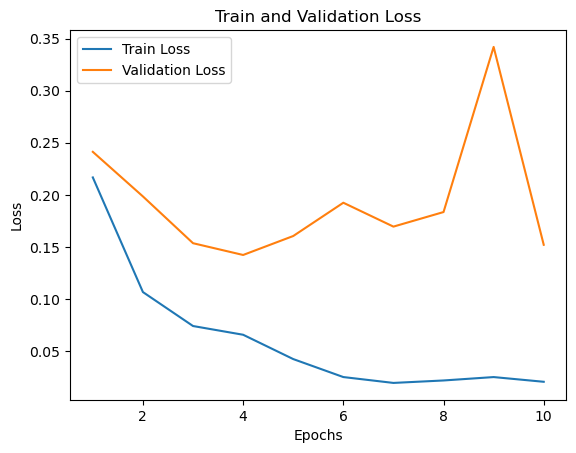

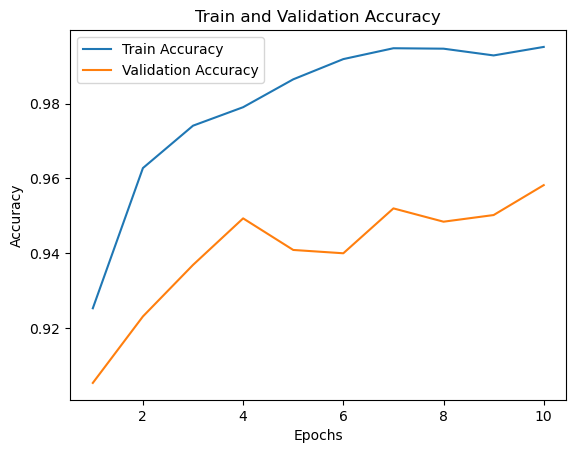

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

# Initialize the KATANA model
model = KATANA().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function with tqdm Progress Bar
def train_katana(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, class_names=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        num_batches = len(train_loader)
        with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for images, knowledge_features, labels in train_loader:
                images, knowledge_features, labels = images.to(device), knowledge_features.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images, knowledge_features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                pbar.update(1)
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

        # Calculate training metrics
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct.double() / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())
        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        num_val_batches = len(val_loader)
        with tqdm(total=num_val_batches, desc="Validating", unit="batch", leave=False) as pbar_val:
            with torch.no_grad():
                for images, knowledge_features, labels in val_loader:
                    images, knowledge_features, labels = images.to(device), knowledge_features.to(device), labels.to(device)
                    outputs = model(images, knowledge_features)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item() * images.size(0)

                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    pbar_val.update(1)

        # Calculate validation metrics
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        val_f1_weighted = f1_score(val_labels, val_preds, average='weighted')
        val_f1_per_class = f1_score(val_labels, val_preds, average=None)

        print(f"Epoch {epoch + 1}/{num_epochs}: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1 (Weighted): {val_f1_weighted:.4f}")

        # Per-Class F1 Scores
        if class_names:
            print("\nPer-Class F1 Scores:")
            for class_name, f1 in zip(class_names, val_f1_per_class):
                print(f"{class_name}: {f1:.4f}")
        else:
            print("\nPer-Class F1 Scores:")
            for i, f1 in enumerate(val_f1_per_class):
                print(f"Class {i}: {f1:.4f}")

    # Plot Training/Validation Loss and Accuracy
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Plotting Function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure()
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_curve.png')
    plt.show()

    # Accuracy Plot
    plt.figure()
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_curve.png')
    plt.show()

# Example Usage
class_names = ["Class A", "Class B", "Class C"]  # Replace with your class names
train_katana(model, combined_train_loader, val_loader, criterion, optimizer, num_epochs=10, class_names=class_names)

# Save the final trained model
torch.save(model.state_dict(), "katana_final_model.pth")




In [144]:
from sklearn.metrics import classification_report

def test_katana(model, test_loader, criterion, class_names=None):
    global test_labels, test_preds 
    model.load_state_dict(torch.load("katana_final_model.pth"))
    model.eval()
    test_correct = 0
    test_total = 0
    test_preds = []
    test_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for images, knowledge_features, labels in tqdm(test_loader, desc="Testing"):
            images, knowledge_features, labels = images.to(device), knowledge_features.to(device), labels.to(device)
            outputs = model(images, knowledge_features)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            # Collect predictions and labels for F1 score
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Calculate test metrics
    test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')
    test_f1_per_class = f1_score(test_labels, test_preds, average=None)
    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / test_total

    # Print overall metrics
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Weighted F1 Score: {test_f1_weighted:.4f}")

    # Print per-class F1 scores
    if class_names is not None:
        print("\nPer-Class F1 Scores:")
        for class_name, f1 in zip(class_names, test_f1_per_class):
            print(f"{class_name}: {f1:.4f}")
    else:
        print("\nPer-Class F1 Scores:")
        for i, f1 in enumerate(test_f1_per_class):
            print(f"Class {i}: {f1:.4f}")

    # Optional: Classification report
    if class_names is not None:
        print("\nClassification Report:")
        print(classification_report(test_labels, test_preds, target_names=class_names))
    else:
        print("\nClassification Report:")
        print(classification_report(test_labels, test_preds))


In [164]:
test_katana(model, test_loader, criterion)

C:\Users\liuha\AppData\Local\Temp\ipykernel_4376\308201914.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("katana_final_model.pth"))
Te

Test Loss: 0.1713, Test Accuracy: 0.9551, Weighted F1 Score: 0.9551

Per-Class F1 Scores:
Class 0: 0.9303
Class 1: 0.9931
Class 2: 0.9430

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       734
           1       0.99      0.99      0.99       728
           2       0.93      0.96      0.94       788

    accuracy                           0.96      2250
   macro avg       0.96      0.96      0.96      2250
weighted avg       0.96      0.96      0.96      2250



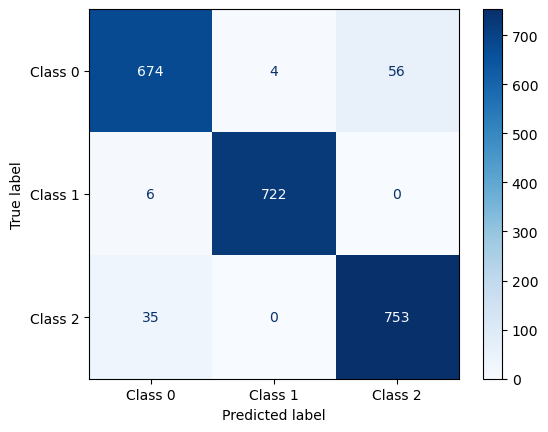

In [166]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap='Blues')
